In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize
import scipy
import seaborn as sns

FILE_PATH = './2022_HiMCM_Data_Datetime.xlsx'
FILE_PATH_NON_DATE_INDEX = './2022_HiMCM_Data.xlsx'
CO2_PPM_ANNUALLY_NON_DATE_INDEX = pd.read_excel(FILE_PATH_NON_DATE_INDEX, sheet_name='CO2 Data Set 1', index_col='Year')
CO2_PPM_ANNUALLY = pd.read_excel(FILE_PATH, sheet_name='CO2 Data Set 1', index_col='Year')
TEMPERATURE_ANNUALLY_NON_DATE_INDEX = pd.read_excel(FILE_PATH_NON_DATE_INDEX, sheet_name='Temps Data Set 2', index_col='Year')
CO2_PPM_ANNUALLY.index = CO2_PPM_ANNUALLY.index.to_period('Y')
# TEMPERATURE_ANNUALLY.index = TEMPERATURE_ANNUALLY.index.to_period('Y').to_timestamp()
CO2_PPM_ANNUALLY

,PPM
Year,
1959,315.98
1960,316.91
1961,317.64
1962,318.45
1963,318.99
...,...
2017,406.76
2018,408.72
2019,411.66


array([ 0.84634101,  0.79125446, -0.86461376])

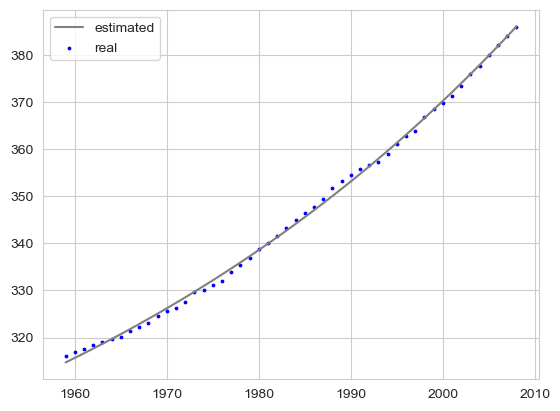

In [2]:
from pmdarima.arima import ADFTest

set_cnt = CO2_PPM_ANNUALLY_NON_DATE_INDEX.shape[0]
train_cnt = int(set_cnt * 0.8)
test_cnt = set_cnt - train_cnt
train_set = CO2_PPM_ANNUALLY_NON_DATE_INDEX[:train_cnt]

x = train_set.index.to_list()
x = np.array(x, dtype=float)
y = train_set.values.squeeze(1)

MIN_X = np.min(x)
SCALE_X = np.max(x) - np.min(x)

MIN_Y = np.min(y)
SCALE_Y = np.max(y) - np.min(y)

x -= MIN_X; x /= SCALE_X
y -= MIN_Y; y /= SCALE_Y

def f(X, a, b, c):
    return a*np.exp(b*X)+c

popt, pcov = scipy.optimize.curve_fit(f, x, y)

plt.plot(x*SCALE_X+MIN_X, f(x, *popt)*SCALE_Y+MIN_Y, color='grey', label='estimated')
plt.scatter(x*SCALE_X+MIN_X, y*SCALE_Y+MIN_Y, s=3, color='blue', label='real')
plt.legend()

popt

array([ 1.2763512 ,  1.2439789 ,  0.99594001,  0.8119795 ,  0.34183817,
       -0.05474739, -0.67804487, -0.40832634, -0.67586826, -0.90095164,
       -0.44386203, -0.51488963, -1.02432939, -1.05248103, -0.01964917,
       -0.71614338, -1.00227827, -1.34837357, -0.80475423, -0.52175047,
       -0.3996979 ,  0.19106242,  0.20018387,  0.18731419,  0.46209538,
        0.76416361,  0.80314914,  0.5986762 ,  0.81036291,  1.67782116,
        1.65065655,  1.33846823,  1.00084883,  0.22738436, -0.74234592,
       -0.65876958, -0.34232118, -0.29344233, -0.90258185,  0.27980415,
        0.17325214, -0.49270897, -0.74855795, -0.51478133,  0.08812641,
       -0.15033724,  0.13931702,  0.22657017,  0.10089475, -0.17824529])

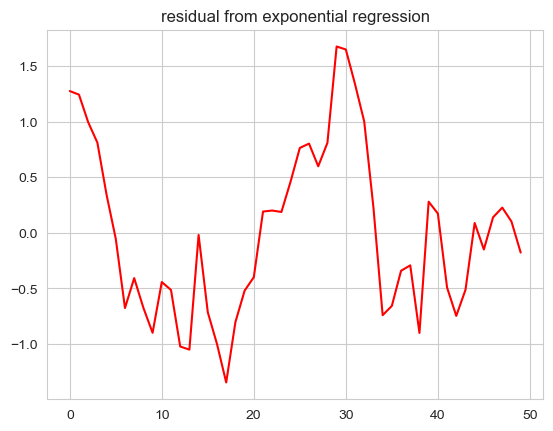

In [3]:
residual = (y - f(x, *popt)) * SCALE_Y

plt.plot(residual, color='red')
plt.title("residual from exponential regression")
residual

<AxesSubplot:ylabel='Count'>

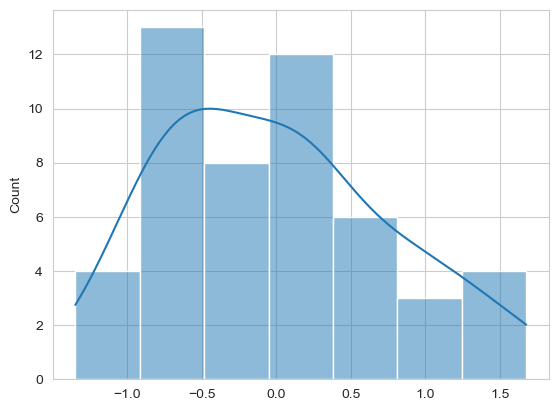

In [4]:
sns.histplot(residual, kde=True)

,PPM
Year,
1959,1.276351
1960,1.243979
1961,0.995940
1962,0.811979
1963,0.341838
1964,-0.054747
1965,-0.678045
1966,-0.408326
1967,-0.675868


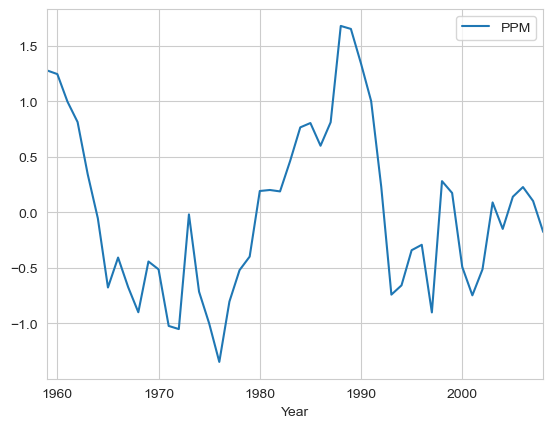

In [5]:
residual_series = pd.DataFrame(index=CO2_PPM_ANNUALLY[:train_cnt].index, data=residual, columns=['PPM'])
residual_series.plot()

residual_series

In [6]:
from pmdarima.arima import ADFTest

adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(residual_series)

(0.3457002384817186, True)

(0.21873647391149711, True)

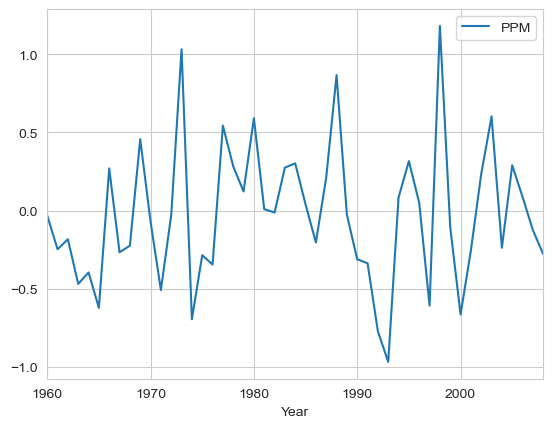

In [7]:
diff_1 = residual_series.diff().dropna()
diff_1.plot()
adf_test.should_diff(diff_1)

(0.01, False)

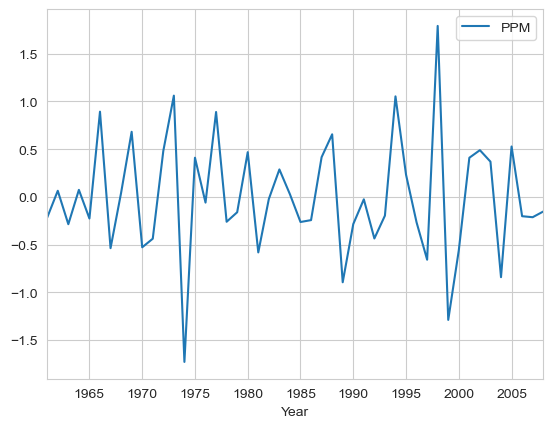

In [8]:
diff_2 = diff_1.diff().dropna()
diff_2.plot()
adf_test.should_diff(diff_2)

In [9]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(residual_series, order=(2, 2, 5))
fitted = model.fit()
fitted.summary()

D:\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    PPM   No. Observations:                   50
Model:                 ARIMA(2, 2, 5)   Log Likelihood                 -25.498
Date:                Mon, 13 Mar 2023   AIC                             66.995
Time:                        19:24:57   BIC                             81.965
Sample:                    12-31-1959   HQIC                            72.652
                         - 12-31-2008                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3288      0.075     -4.389      0.000      -0.476      -0.182
ar.L2         -0.9986      0.035    -28.903      0.000      -1.066      -0.931
ma.L1         -0.4868   2483.501     -0.000      1.000   -4868.058    4867.085
ma.L2          0.7336   1274.718      0.001      1.000   -2497.669    2499.136
ma.L3         -1.0268   3096.283     -0.000      1.000   -6069.629    6067.576
ma.L4         -0.0165    546.469  -3.01e-05      1.000   -1071.075    1071.042
ma.L5         -0.2036    505.635     -0.000      1.000    -991.230     990.823
sigma2         0.1420    352.493      0.000      1.000    -690.731     691.015
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                 1.34
Prob(Q):                              0.65   Prob(JB):                         0.51
Heteroskedasticity (H):               0.94   Skew:                             0.40
Prob(H) (two-sided):                  0.90   Kurtosis:                         3.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Year'>

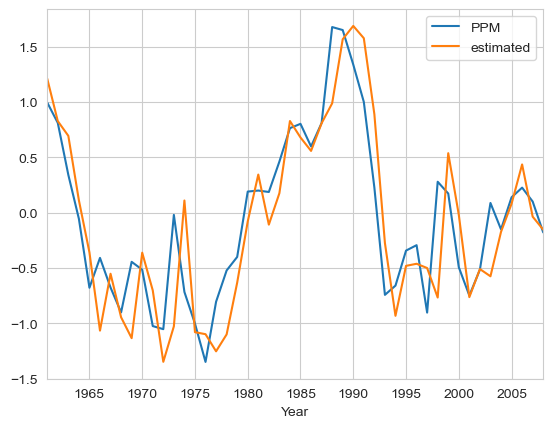

In [10]:
residual_series[2:].plot()
estimated_residual = fitted.predict(2, train_cnt-1)
estimated_residual.plot(legend=True, label='estimated')

In [12]:
actual_data = CO2_PPM_ANNUALLY[:train_cnt]
estimated_data = estimated_residual + f(x, *popt)[2:] * SCALE_Y + MIN_Y
estimated_data

Year
1961    317.855667
1962    318.465911
1963    319.342790
1964    319.787295
1965    320.359601
1966    320.712926
1967    322.304373
1968    323.006018
1969    323.930190
1970    325.833769
1971    326.642577
1972    327.165007
1973    328.672807
1974    331.016476
1975    331.052646
1976    332.280671
1977    333.392174
1978    334.832090
1979    336.607623
1980    338.490099
1981    340.264574
1982    341.184936
1983    342.864379
1984    344.934410
1985    346.226762
1986    347.569820
1987    349.308148
1988    351.000884
1989    353.117007
1990    354.799505
1991    356.275931
1992    357.202332
1993    357.677783
1994    358.686951
1995    360.832032
1996    362.572012
1997    364.282758
1998    365.793542
1999    368.904608
2000    370.183860
2001    371.305620
2002    373.455554
2003    375.317423
2004    377.676990
2005    379.921716
2006    382.299603
2007    383.883343
2008    385.855059
Freq: A-DEC, Name: predicted_mean, dtype: float64

<AxesSubplot:xlabel='Year'>

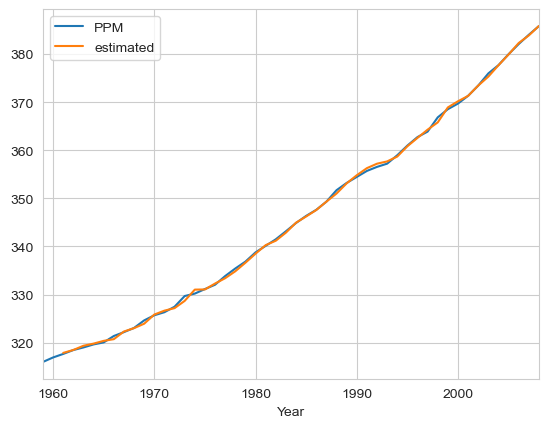

In [13]:
actual_data.plot()
estimated_data.plot(legend=True, label='estimated')

In [14]:
import math

estimated_data.name='PPM'
actual_data_list = actual_data.values.squeeze(1)
estimated_data_list = estimated_data.values
RMSE = math.sqrt(np.square(actual_data_list[2:]-estimated_data_list).mean())
RMSE

0.4060831991917254

<AxesSubplot:xlabel='Year'>

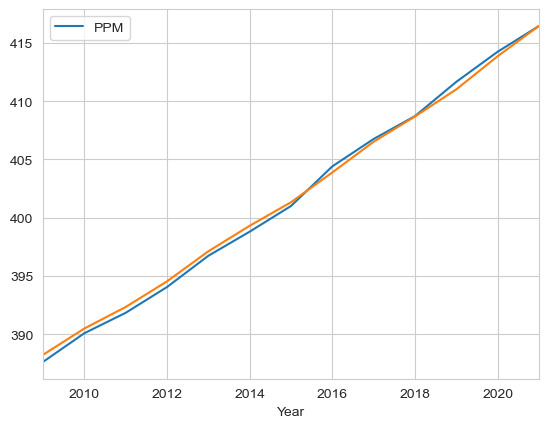

In [16]:
actual_data_for_forecast = CO2_PPM_ANNUALLY[train_cnt:]
forecast_data = fitted.forecast(test_cnt)
forecast_x = CO2_PPM_ANNUALLY_NON_DATE_INDEX[train_cnt:].index.to_numpy(dtype=float)
forecast_x -= MIN_X
forecast_x /= SCALE_X
forecast_data += f(forecast_x, *popt) * SCALE_Y + MIN_Y
actual_data_for_forecast.plot()
forecast_data.plot()

In [17]:
actual_data_for_forecast = actual_data_for_forecast.values.squeeze(1)
forecast_data_ndarray = forecast_data
RMSE2 = math.sqrt(np.square(actual_data_for_forecast-forecast_data_ndarray).mean())
RMSE2

0.4308687586232895

In [18]:
MAE = np.abs(actual_data_for_forecast - forecast_data_ndarray).mean()
MAE

0.38718386000296223

In [19]:
MRE = (np.abs(actual_data_for_forecast-forecast_data_ndarray)/actual_data_for_forecast).mean()
MRE

0.0009697357808389132

In [20]:
from scipy.stats import pearsonr

(pearsonr(actual_data_for_forecast, forecast_data_ndarray)[0])**2

0.9991817042963754

In [21]:
from dtaidistance import dtw
dtw.distance(actual_data_for_forecast, forecast_data_ndarray)

numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject


1.5535194022117873